In [1]:
import pandas as pd
import numpy as np
import codecs
import konlpy
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer 
from keras.layers import Embedding, Dense, LSTM 
from keras.models import Sequential 
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


### Data import

In [2]:
train_new=pd.read_csv('./train_newlabel.csv', encoding='utf-8',index_col=False)
train_old=pd.read_csv('./train_oldlabel.csv', encoding='utf-8',index_col=False)
test_old=pd.read_csv('./test_oldlabel.csv', encoding='utf-8',index_col=False)
test_new=pd.read_csv('./test_newlabel.csv', encoding='utf-8',index_col=False)

In [3]:
#train_new.drop(train_new.columns[[0]], axis=1, inplace=True) # 36027
# 10만개만 추출
train_new=train_new.iloc[:100000,:] # 14500
#train_old.drop(train_old.columns[[0]], axis=1, inplace=True) # 7511
#test_old.drop(test_old.columns[[0]], axis=1, inplace=True) # 161
#test_new.drop(test_new.columns[[0]], axis=1, inplace=True) # 700

In [4]:
train_new

,Unnamed: 0,title,newlabel
0,0,"<유>한성기업, 전일 대비 7.51% 상승.. 일일회전율은 2.20% 기록 ...",0
1,1,"기업회원 87.2％ ""정부 및 지자체의 소상공인 지원 환영""<알바천국> ...",0
2,2,"태국, 세 번째 비상사태 연장에 ""코로나 때문 vs 정치적 목적"" ...",0
3,3,"[포토] 서울농협, GKL 임직원과 농촌봉사활동 ...",1
4,4,"현대차, 군사 부문 수소전기차,충전소 보급 확대 ...",0
...,...,...,...
99995,99995,"인천·속초·수원, '스마트관광 도시' 후보지로 선정 ...",0
99996,99996,"'케어젠' 52주 신고가 경신, 전일 기관 대량 순매수 ...",0
99997,99997,"홈플러스, ‘시그니처 캔커피’ 출시 2주만에 25만개 돌파 ...",1
99998,99998,안동 등 경북 3곳 폭염주의보 ...,0


### 스팸 단어 리스트 import / test newlabel 구하기

In [5]:
positive = [] 

pos = codecs.open('./pos_2.txt', 'r') 
while True: 
    line = pos.readline() 
    line = line.replace('\n', '') 
    positive.append(line) 
    if not line: 
        break 
        
pos.close()
positive.pop() # 마지막 값 제거 ('')

''

In [6]:
titles=test_old.title
label = [0] * len(titles)
my_title_dic = {"title":[], "newlabel":label}

j = 0
for data in titles: 
    my_title_dic['title'].append(data)

    for i in range(len(positive)): 
        posflag = False  
        if data.find(positive[i]) != -1: 
            posflag = True 
            break 

        else:
            posflag = False 

    if posflag == True: 
        label[j] = 1 
    else: 
        label[j] = 0

    j=j+1 
    
my_title_dic['newlabel'] = label 
my_title_df = pd.DataFrame(my_title_dic)

In [7]:
sum(label)

700

In [23]:
def dftoCsv(my_title_df): 
    my_title_df.to_csv(('./test_newlabel.csv'), sep=',', na_rep='NaN', encoding='utf-8')
dftoCsv(my_title_df)

In [22]:
test_old

,title,label
0,"콜마비앤에이치(200130), 52주 신고가 ...",0
1,VC 투자+기보 보증 ‘레버리지보증’ 나왔다 ...,0
2,[인사]예금보험공사 ...,0
3,"'삼부토건' 5% 이상 상승, 전일 외국인 대량 순매수 ...",0
4,숨랩 | 여름용 마스크 ‘라이트 마스크’ 뜨거운 반응 ...,0
...,...,...
5126,"에스엔유(080000) 소폭 상승세 +4.51%, 닷새째 상승 ...",0
5127,"건보공단, 아프리카 감비아에 '건강보험 통합패키지' 전파 추진 ...",0
5128,완도군-목포대 '2021 완도국제해조류박람회' 성공개최 맞손 ...,0
5129,[윤중로] 코로나 묵시록 ...,0


In [18]:
def dftoCsv(my_title_df): 
    my_title_df.to_csv(('./train_newlabel.csv'), sep=',', na_rep='NaN', encoding='utf-8')
dftoCsv(my_title_df)

### Data preprocessing

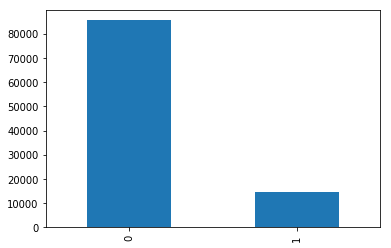

In [8]:
%matplotlib inline 
import matplotlib.pyplot as plt

train_new['newlabel'].value_counts().plot(kind='bar')

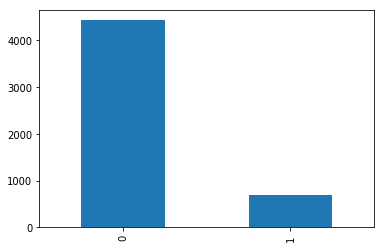

In [9]:
test_new['newlabel'].value_counts().plot(kind='bar')

In [10]:
print(train_new.groupby('newlabel').size().reset_index(name='count')) 
print(test_new.groupby('newlabel').size().reset_index(name='count'))

   newlabel  count
0         0  85500
1         1  14500
   newlabel  count
0         0   4431
1         1    700


#### 불용어 제거

In [11]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [12]:
# 형태소 추출 후 불용어 제거
okt = Okt()
X_train = [] 
for sentence in train_new['title']: 
    temp_X = [] 
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
    X_train.append(temp_X)
X_test = [] 
for sentence in test_new['title']: 
    temp_X = [] 
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
    X_test.append(temp_X)

#### 토큰화: 단어들에 고유 번호 부여, 계산 처리하기 용이하기 때문

In [13]:
# 정수 인코딩
max_words = 35000 
tokenizer = Tokenizer(num_words = max_words) 
tokenizer.fit_on_texts(X_train) 
X_train = tokenizer.texts_to_sequences(X_train) 
X_test = tokenizer.texts_to_sequences(X_test)

#### 각 데이터 별 제목 최대 길이 추출 -> input 길이를 맞춰야 함

제목의 최대 길이 :  50
제목의 평균 길이 :  12.78352


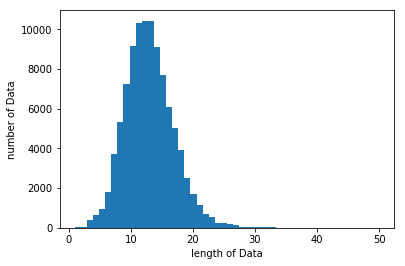

In [14]:
# train
print("제목의 최대 길이 : ", max(len(l) for l in X_train)) 
print("제목의 평균 길이 : ", sum(map(len, X_train))/ len(X_train)) 
plt.hist([len(s) for s in X_train], bins=50) 
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.show()

제목의 최대 길이 :  30
제목의 평균 길이 :  12.796530890664588


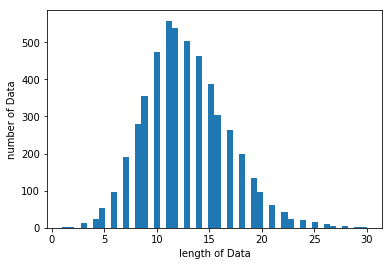

In [15]:
# test
print("제목의 최대 길이 : ", max(len(l) for l in X_test)) 
print("제목의 평균 길이 : ", sum(map(len, X_test))/ len(X_test)) 
plt.hist([len(s) for s in X_test], bins=50) 
plt.xlabel('length of Data') 
plt.ylabel('number of Data') 
plt.show()

In [16]:
# y값 one-hot encoding
import numpy as np 
y_train = [] 
y_test = [] 
for i in range(len(train_new['newlabel'])): 
    if train_new['newlabel'].iloc[i] == 1: 
        y_train.append([0, 1]) 
    elif train_new['newlabel'].iloc[i] == 0: 
        y_train.append([1, 0]) 
        
y_train = np.array(y_train) 


for i in range(len(test_new['newlabel'])): 
    if test_new['newlabel'].iloc[i] == 1: 
        y_test.append([0, 1]) 
    elif test_new['newlabel'].iloc[i] == 0: 
        y_test.append([1, 0]) 

y_test = np.array(y_test)

In [53]:
train_new

,Unnamed: 0,title,newlabel
0,0,"<유>한성기업, 전일 대비 7.51% 상승.. 일일회전율은 2.20% 기록 ...",0
1,1,"기업회원 87.2％ ""정부 및 지자체의 소상공인 지원 환영""<알바천국> ...",0
2,2,"태국, 세 번째 비상사태 연장에 ""코로나 때문 vs 정치적 목적"" ...",0
3,3,"[포토] 서울농협, GKL 임직원과 농촌봉사활동 ...",1
4,4,"현대차, 군사 부문 수소전기차,충전소 보급 확대 ...",0
...,...,...,...
99995,99995,"인천·속초·수원, '스마트관광 도시' 후보지로 선정 ...",0
99996,99996,"'케어젠' 52주 신고가 경신, 전일 기관 대량 순매수 ...",0
99997,99997,"홈플러스, ‘시그니처 캔커피’ 출시 2주만에 25만개 돌파 ...",1
99998,99998,안동 등 경북 3곳 폭염주의보 ...,0


In [17]:
max_len = 50 # 전체 데이터의 길이를 20로 맞춘다 
X_train = pad_sequences(X_train, maxlen=max_len) 
X_test = pad_sequences(X_test, maxlen=max_len)

### Modeling

In [18]:
# Early Stopping 추가
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

model = Sequential() 
model.add(Embedding(max_words, 100)) 
model.add(LSTM(128)) 
model.add(Dense(2, activation='softmax')) 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', auroc]) 
early_stopping = EarlyStopping() 
history = model.fit(X_train, y_train, epochs=10, batch_size=3000, validation_split=0.1, callbacks=[early_stopping])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 90000 samples, validate on 10000 samples
Epoch 1/10
90000/90000 [==============================] - 79s 880us/step - loss: 0.4556 - acc: 0.8416 - auroc: 0.7766 - val_loss: 0.3284 - val_acc: 0.8603 - val_auroc: 0.9365
Epoch 2/10
90000/90000 [==============================] - 80s 884us/step - loss: 0.2351 - acc: 0.9010 - auroc: 0.9470 - val_loss: 0.1755 - val_acc: 0.9329 - val_auroc: 0.9524
Epoch 3/10
90000/90000 [==============================] - 78s 869us/step - loss: 0.1022 - acc: 0.9640 - auroc: 0.9855 - val_loss: 0.0840 - val_acc: 0.9729 - val_auroc: 0.9879
Epoch 4/10
90000/90000 [==============================] - 77s 859us/step - loss: 0.0283 - acc: 0.9928 - auroc: 0.9985 - val_loss: 0.0428 - val_acc: 0.9890 - val_auroc: 0.9933
Epoch 5/10
90000/90000 [==============================] - 77s 856us/step - loss: 0.0096 - acc: 0.9978 - auroc: 0.9997 - val_loss: 0.0407 - val_acc: 0.

In [73]:
loss_and_metrics

[0.05616756400398008, 0.9877216906673935, 0.9893730923665609]

### epoch 별 loss

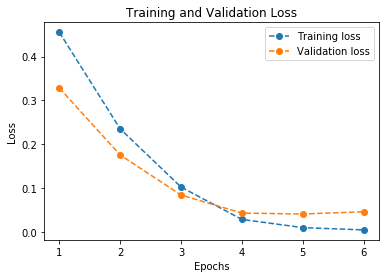

In [19]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, linestyle='--', marker='o', label='Training loss')  # ‘bo’는 점을 의미합니다.
plt.plot(epochs, val_loss, linestyle='--', marker='o',  label='Validation loss') # ‘b’는 실선을 의미합니다.
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
fig = plt.gcf()
fig.savefig('loss_3000.png')
plt.show()


### epoch 별 accuracy

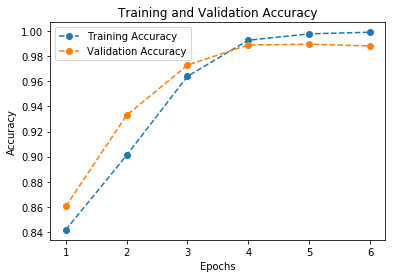

In [20]:
plt.clf() # 그래프를 초기화합니다.
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, linestyle='--', marker='o', label='Training Accuracy')  # ‘bo’는 점을 의미합니다.
plt.plot(epochs, val_acc, linestyle='--', marker='o',  label='Validation Accuracy') # ‘b’는 실선을 의미합니다.

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
fig = plt.gcf()
fig.savefig('accuracy_3000.png')
plt.show()


### epoch 별 auc

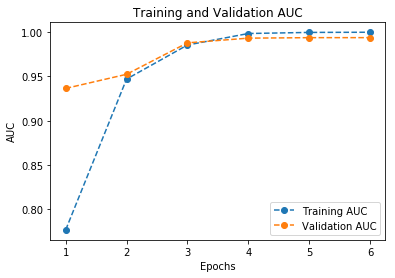

In [21]:
acc = history_dict['auroc']
val_acc = history_dict['val_auroc']

plt.plot(epochs, acc, linestyle='--', marker='o', label='Training AUC')
plt.plot(epochs, val_acc, linestyle='--', marker='o', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
fig = plt.gcf()
fig.savefig('auc_3000.png')
plt.show()


## Model Evaluation

In [72]:
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=2000)

5131/5131 [==============================] - 1s 235us/step


In [22]:
predict = model.predict(X_test)
import numpy as np 
predict_labels = np.argmax(predict, axis=1) 
original_labels = np.argmax(y_test, axis=1)
for i in range(10): 
    print("기사제목 : ", test_new['title'].iloc[i], "/\t 원래 라벨 : ", original_labels[i], "/\t예측한 라벨 : ", predict_labels[i])


기사제목 :  콜마비앤에이치(200130), 52주 신고가                                                                                                                    /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사제목 :  VC 투자+기보 보증 ‘레버리지보증’ 나왔다                                                                                                              /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사제목 :  [인사]예금보험공사                                                                                                                                     /	 원래 라벨 :  1 /	예측한 라벨 :  1
기사제목 :  '삼부토건' 5% 이상 상승, 전일 외국인 대량 순매수                                                                                                       /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사제목 :  숨랩 | 여름용 마스크 ‘라이트 마스크’ 뜨거운 반응                                                                                                     /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사제목 :  잇츠한불(226320) 현재 13.97% 상승                                                                                                           

In [23]:
sum(predict_labels==original_labels)/len(predict_labels)

0.9873319041122588

In [77]:
len(predict_labels)

5131

In [78]:
sum(predict_labels)

705

In [99]:
sum(predict_labels==original_labels)

5068

In [100]:
len(predict_labels)

5131

In [101]:
from sklearn.metrics import confusion_matrix

y_true = original_labels
y_pred = predict_labels

confusion_matrix(y_true, y_pred)

array([[4397,   34],
       [  29,  671]], dtype=int64)

In [110]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['normal', 'spam']))

              precision    recall  f1-score   support

      normal       0.99      0.99      0.99      4431
        spam       0.95      0.96      0.96       700

    accuracy                           0.99      5131
   macro avg       0.97      0.98      0.97      5131
weighted avg       0.99      0.99      0.99      5131



In [24]:
predict_labels

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [26]:
predict = model.predict(X_test)
import numpy as np 
predict_labels = np.argmax(predict, axis=1) 
original_labels = np.argmax(y_test, axis=1)

for i in range(len(predict_labels)): 
    if predict_labels[i]!=original_labels[i]:
        print("기사제목 : ", test_new['title'].iloc[i], "/\t 원래 라벨 : ", original_labels[i], "/\t예측한 라벨 : ", predict_labels[i])


기사제목 :  돌아온 野, ‘일하는 국회법’?‘윤석열 특검’ 앞세워 대여 투쟁 가속                                                                                     /	 원래 라벨 :  1 /	예측한 라벨 :  0
기사제목 :  하나은행, `+α금리` 주는 청년직장인 맞춤적금                                                                                                           /	 원래 라벨 :  0 /	예측한 라벨 :  1
기사제목 :  윤건영 "박지원 국정원장 내정, 협치·탕평인사의 끝판"                                                                                                   /	 원래 라벨 :  1 /	예측한 라벨 :  0
기사제목 :  "中, 올해 美에너지 수입 목표달성 어려워…1~5월 이행률 18% 불과"                                                                                        /	 원래 라벨 :  1 /	예측한 라벨 :  0
기사제목 :  중국서 또 터졌다…코로나 이어 돼지열병·흑사병까지 [종합]                                                                                              /	 원래 라벨 :  1 /	예측한 라벨 :  0
기사제목 :  [IPO정보] [티에스아이 IR팀] 새로운 기업설명회 자료가 등록되었습니다.                                                                                   /	 원래 라벨 :  0 /	예측한 라벨 :  1
기사제목 :  삼광글라스, '보에나'

In [27]:
for i in range(20): 
    if predict_labels[i]==original_labels[i]:
        print("기사제목 : ", test_new['title'].iloc[i], "/\t 원래 라벨 : ", original_labels[i], "/\t예측한 라벨 : ", predict_labels[i])


기사제목 :  콜마비앤에이치(200130), 52주 신고가                                                                                                                    /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사제목 :  VC 투자+기보 보증 ‘레버리지보증’ 나왔다                                                                                                              /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사제목 :  [인사]예금보험공사                                                                                                                                     /	 원래 라벨 :  1 /	예측한 라벨 :  1
기사제목 :  '삼부토건' 5% 이상 상승, 전일 외국인 대량 순매수                                                                                                       /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사제목 :  숨랩 | 여름용 마스크 ‘라이트 마스크’ 뜨거운 반응                                                                                                     /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사제목 :  잇츠한불(226320) 현재 13.97% 상승                                                                                                           

In [30]:
for i in range(20): 
    if test_old.label[i]==predict_labels[i]:
        print("기사제목 : ", test_new['title'].iloc[i], "/\t 원래 nh 라벨 : ", original_labels[i], "/\t예측한 라벨 : ", predict_labels[i])


기사제목 :  콜마비앤에이치(200130), 52주 신고가                                                                                                                    /	 원래 nh 라벨 :  0 /	예측한 라벨 :  0
기사제목 :  VC 투자+기보 보증 ‘레버리지보증’ 나왔다                                                                                                              /	 원래 nh 라벨 :  0 /	예측한 라벨 :  0
기사제목 :  '삼부토건' 5% 이상 상승, 전일 외국인 대량 순매수                                                                                                       /	 원래 nh 라벨 :  0 /	예측한 라벨 :  0
기사제목 :  숨랩 | 여름용 마스크 ‘라이트 마스크’ 뜨거운 반응                                                                                                     /	 원래 nh 라벨 :  0 /	예측한 라벨 :  0
기사제목 :  잇츠한불(226320) 현재 13.97% 상승                                                                                                                      /	 원래 nh 라벨 :  0 /	예측한 라벨 :  0
기사제목 :  넷마블, +2.82% 52주 신고가                                                                                                  

In [28]:
test_old

,Unnamed: 0,title,label
0,2831,"콜마비앤에이치(200130), 52주 신고가 ...",0
1,4686,VC 투자+기보 보증 ‘레버리지보증’ 나왔다 ...,0
2,3419,[인사]예금보험공사 ...,0
3,2209,"'삼부토건' 5% 이상 상승, 전일 외국인 대량 순매수 ...",0
4,1421,숨랩 | 여름용 마스크 ‘라이트 마스크’ 뜨거운 반응 ...,0
...,...,...,...
5126,447,"에스엔유(080000) 소폭 상승세 +4.51%, 닷새째 상승 ...",0
5127,1663,"건보공단, 아프리카 감비아에 '건강보험 통합패키지' 전파 추진 ...",0
5128,306,완도군-목포대 '2021 완도국제해조류박람회' 성공개최 맞손 ...,0
5129,2501,[윤중로] 코로나 묵시록 ...,0


In [31]:
predict_labels

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [33]:
sum(test_old.label==predict_labels)/len(predict_labels)

0.8717598908594816

In [58]:
sum(test_old.label!=predict_labels)/len(predict_labels)

0.12824010914051842

### Tokenization example

In [48]:
from konlpy.tag import Okt
okt=Okt()

In [57]:
sentence='버핏, 미국 천연가스 운송·저장설비 4조8천억에 인수'
sentence

'버핏, 미국 천연가스 운송·저장설비 4조8천억에 인수'

In [49]:
K_nouns=okt.morphs(sentence, stem=True)
K_nouns

['버핏', ',', '미국', '천연가스', '운송', '·', '저장', '설비', '4조', '8천억', '에', '인수']

In [51]:
stopwords = [',','·', '에', '은', '들', '는', '좀', '잘', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [52]:
K_nouns = [word for word in K_nouns if not word in stopwords]  
K_nouns

['버핏', '미국', '천연가스', '운송', '저장', '설비', '4조', '8천억', '인수']